# Building Your First ARTKIT Pipeline

## Introduction

This notebook introduces the basic building blocks for developing ARTKIT testing and evaluation pipelines. You will learn how to:

1. **Set up your environment:** Import ARTKIT and supporting libraries, set up logging, and load environment variables.
2. **Connect to an LLM:** Establish a secure API connection with OpenAI, enabling you to send requests and receive responses.
3. **Learn core ARTKIT functions:** Get familiar with ARTKIT's flexible functions to build a basic pipeline.
4. **Build E2E test & eval pipeline:** Define and run a simple end-to-end testing and evaluation pipeline.

The functions introduced in this tutorial enable developers to address a wide range of testing and evaluation use cases with ARTKIT. 

New users are encouraged to start with the ARTKIT setup guide on the documentation [Home](../../_generated/home.rst#installation) page and the [Gen AI Testing and Evaluation](genai_testing_and_evaluation.rst) overview in our User Guide. 

## Setup

The recommended way to use ARTKIT is to import `artkit.api` with the alias `ak`, since the `api` module provides a clean interface to all ARTKIT methods and classes which are designed to be user-facing.

We also import the standard library `json`, which is useful for converting JSON formatted outputs from LLMs into Python dictionaries

In [1]:
import json

import artkit.api as ak

ARTKIT is designed to work in conjunction with `pandas` for data processing. The display setting below is helpful for viewing dataframes in notebooks when there are long strings in the cells, which occurs frequently when working with prompts. 

In [2]:
import pandas as pd

pd.set_option("display.max_colwidth", None)

ARTKIT supports detailed logging. In this notebook, we set the logging level to WARNING to keep the outputs minimal. When developing your own ARTKIT pipelines, it may be helpful to set the logging level to INFO or DEBUG for richer outputs.

In [3]:
import logging

logging.basicConfig(level=logging.WARNING)

This notebook interacts with the OpenAI API. To run this notebook, obtain an [OpenAI API key](https://platform.openai.com/docs/quickstart/account-setup) and store it in an environment variable called `OPENAI_API_KEY`. For a step-by-step guide, see our documentation on [Environment Variables](../../_generated/home.rst#environment-variables). 

We recommend storing environment variables in a `.env` file within your project and loading them using `load_dotenv`, as shown below:

In [4]:
from dotenv import load_dotenv
load_dotenv();

## Connect to an LLM

ARTKIT model classes provide interfaces for connecting to a variety Gen AI models from different model providers, including OpenAI, Anthropic, HuggingFace, Groq, and Google Vertex AI. Benefits of using ARTKIT model classes include built-in support for asynchronous requests and managing chat history.

The codeblock below uses ARTKIT's `OpenAIChat` model class to initiate a client session with GPT-4. ARTKIT is designed to work asynchronously, as this unlocks massive performance gains when running pipelines with many API calls. Accordingly, ARTKIT's built-in LLM connectors are all asynchronous. Later in the tutorial, we demonstrate how to write asynchronous functions to leverage ARTKIT's async capabilities. Note that users can always implement and include non-async functions in ARTKIT pipelines if they choose, but it is strongly recommended to use asynchronous methods whenever possible. 

The `OpenAIChat` model class is passed as the `model` parameter to a `CachedChatModel` class. This optional step allows us to leverage ARTKIT's automatic caching functionality, which caches model responses in a database using Python's built in [sqlit3](https://docs.python.org/3/library/sqlite3.html) library. Using a cache ensures reproducibility and avoids repetitive API calls which can run up costs and runtime during development. The code below specifies a cache database as a file path relative to this notebook:

In [5]:
chat_llm = ak.CachedChatModel(
    model=ak.OpenAIChat(
        model_id="gpt-4",
        temperature=1,
        seed=0,
        api_key_env="OPENAI_API_KEY",
    ),
    database="cache/building_your_first_artkit_pipeline.db"
)

See the [Connecting to Model APIs](connecting_to_genai_models.ipynb) tutorial for an overview of how to use different ARTKIT model classes. The [API Reference](../../apidoc/artkit.rst) contains the most up-to-date list of supported models. 

If you need to connect to a model which is not supported by ARTKIT, see our tutorial on [Creating New Model Classes](../advanced_tutorials/creating_new_model_classes.ipynb), and please consider [Contributing](../../contributor_guide/index.rst) to ARTKIT!

## Core ARTKIT functions

This section introduces the core functions for building ARTKIT pipelines:

1. `run`: Execute one or more pipeline steps
2. `step`: A single pipeline step which produces a dictionary or an iterable of dictionaries
3. `chain` or `>>`: A set of steps that run in sequence
4. `parallel` or `&`: A set of steps that run in parallel

### Run

The `run` function takes two arguments:

1. `steps`: One or more steps to execute
2. `input` (optional): One or more inputs to the steps. This must be a dictionary or an iterable of dictionaries. This is optional since the inputs to a flow can alternatively be defined in an initial step which takes no input arguments and outputs a dictionary or iterable of dictionaries to be passed to the downstream steps. 

The result of executing `run` is always a dictionary or an iterable of dictionaries.

Use of the `run` function will be illustrated in the next section, where we will use it to execute a `step`.

### Step

The `step` function is used to define individual steps in an ARTKIT pipeline. Key characteristics of the `step` function are:

1. The first argument is the name of the step, which is passed through in the pipeline results
2. The second argument can be either:
    - A dictionary or iterable of dictionaries. This is often useful for defining the first step in a pipeline as a fixed set of initial prompts that are passed on to subsequent steps which transform the inputs or send them as inputs to an API.
    - A function which returns a dictionary or an iterable of dictionaries. Aside from the first step in a pipeline, this is typically how `step` is used.
3. Optionally, any additional keyword arguments to be passed to the function

Let's look at a toy example:

In [6]:
ULTIMATE_QUESTION = 'What is the answer to the Ultimate Question of Life, \
    the Universe, and Everything?'

# Define input, which can be a dict or iterable of dicts
question = {'question': ULTIMATE_QUESTION}


# Define function to be used in a step
def ultimate_answer(question: str):
    return {'answer': 42}


# Define step
step_ultimate_answer = ak.step(
    "ultimate_answer",  # Step name
    ultimate_answer,  # Step function to run
)


# Run step with the question passed as the input
result = ak.run(steps=step_ultimate_answer, input=question)
result.to_frame()

,input,ultimate_answer
,question,answer
item,,
0,"What is the answer to the Ultimate Question of Life, the Universe, and Everything?",42


In this non-sensical example, the input question is not actually used by the step, however this illustrates that the input data automatically flows through to the final output. This is significant, because it ensures the input is available in the pipeline output without having to include it as an output of the step.

Note that the `to_frame` method unpacks the dictionary into in a multi-column dataframe where:

1. The first column level represents the name of the step (in the example above, the steps are `input` and `ultimate_answer`)
2. The second column level represents the output from each step (in the example above, the step outputs are `question` and `answer`, respectively)

As we will see later, this two-level column structure becomes extremely helpful in multi-step flows, since it allows us to keep track of which step produced each output.

Now let's look at a more realistic example which uses `chat_llm` to accept an input and return a response from GPT-4. 

In [7]:
# Define step function (technically, an asynchronous generator)
async def gpt4(question: str, llm: ak.ChatModel):
    for response in await llm.get_response(message=question):
        yield dict(response=response)


# Define step
step_gpt4 = ak.step(
    "gpt4",  # Step name
    gpt4,  # Step function to run
    llm=chat_llm,  # LLM system to use
)


# Input prompt
prompt = {'prompt': 'What is the answer to the Ultimate Question \
          of Life, the Universe, and Everything?'}


# Run step with the input prompt
result = ak.run(steps=step_gpt4, input=question)
result.to_frame()

,input,gpt4
,question,response
item,,
0,"What is the answer to the Ultimate Question of Life, the Universe, and Everything?","The answer is 42, according to ""The Hitchhiker's Guide to the Galaxy"" by Douglas Adams."


The step function above introduces a few advanced Python concepts which are powerful and easy to implement with slight adjustments to traditional Python function definition syntax:

- Asynchronous Programming (`async`, `await`):
    - The `async def` syntax is used to define an [asynchronous function](https://docs.python.org/3/library/asyncio.html). Asynchronous functions allow certain operations, typically I/O bound tasks like API calls or file operations, to run without blocking the execution of other parts of your program. This is especially useful in web applications and services where handling multiple tasks concurrently can significantly improve performance.
    - The `await` keyword is used to pause the execution of the surrounding coroutine (asynchronous function) until the awaited task completes. `await` is used here to wait for the response from the asynchronous method call, `llm.get_response_async()`. 
- Generators (`yield`):
    - The `yield` keyword turns a function into a [generator](https://docs.python.org/3/reference/expressions.html#yieldexpr), which is a type of iterator that generates one item at a time and only when required, usually in a loop. Unlike a regular function that terminates once it hits a `return` statement, a generator can yield multiple values over time, pausing after each `yield` and resuming from there the next time it’s called. This is useful when dealing with a potentially large set of results that you don’t want to store in memory all at once.

We *strongly* recommend defining functions as asynchronous generators for ARTKIT pipelines, since this allows you to take full advantage of the library's asynchronous capabilities. For this reason, ARTKIT's built-in model connectors only support asynchronous calls. However, ARTKIT pipelines are perfectly capable of working with non-async functions, and users are free to implement non-async functions and model connectors as needed.

### Chain (>>)

The `chain` function is used to connect steps, such that the outputs of the previous step are available as inputs to the next step. To illustrate this, let's define two functions: 

In [8]:
question = {'question': 'What is the answer to the Ultimate Question \
            of Life, the Universe, and Everything?'}


def step_ultimate_answer(question: str):
    return {'answer': 42}


def step_multiply_answer(answer: str, multiplier: int):
    return {'answer_multiplied': answer * multiplier}

Now we can run these in a pipeline by creating two steps and combining them with `chain`. Within a chain, steps can automatically access items in the output dictionary of the previous step. In the example below, the "answer" in the output from the first step is automatically used as the "answer" argument in the second step. 

In [9]:
chain = ak.chain(
    ak.step("ultimate_answer", step_ultimate_answer),
    ak.step("multiply_answer", step_multiply_answer, multiplier=2),
)


result = ak.run(steps=chain, input=question)
result.to_frame()

,input,ultimate_answer,multiply_answer
,question,answer,answer_multiplied
item,,,
0,"What is the answer to the Ultimate Question of Life, the Universe, and Everything?",42,84


Properties of chains include:

- Chains can be composed of multiple steps
- Chains can be nested within other chains. This can be helpful when developing very complex chains: You can improve code readability and testability by breaking up the problem into simpler sub-chains, which are later combined together in a final pipeline.
- Within a chain, steps automatically match outputs from each step to the input parameters of the next step. For example, if "answer" is in the output dictionary of a step, and if the following step has an input parameter called "answer", then the second step will use the value from the previous step for the "answer" parameter.

### Parallel (&)

The `parallel` function is used to define a set of steps or chains, or *sub-flows*, which will run in parallel. 

All sub-flows inside a `parallel` function must have compatible input and output types, since they will accept the same inputs and the outputs will be combined. To illustrate this function, we will pass the "answer" in as the initial input:

In [10]:
answer = {'answer': 42}


def step_multiply_answer(answer: str, multiplier: int):
    return {'multiplier': multiplier,
            'answer_multiplied': answer * multiplier}


parallel = ak.parallel(
    ak.step("multiply_answer", step_multiply_answer, multiplier=1),
    ak.step("multiply_answer", step_multiply_answer, multiplier=2),
    ak.step("multiply_answer", step_multiply_answer, multiplier=3),
)


result = ak.run(steps=parallel, input=answer)
result.to_frame().sort_values(by=("multiply_answer", "multiplier"))

input multiply_answer                  
     answer      multiplier answer_multiplied
item                                         
0        42               1                42
0        42               2                84
0        42               3               126

Properties of parallel steps include:

- A set of parallel steps can itself be part of a chain
- Chains can be used inside parallel steps

In the output above you can also clearly see the multi-level index for columns, where again the first level denotes the name of the step and the second level the output.

### Putting it all together

The four functions `run`, `step`, `chain`, and `parallel` can be flexibly combined to create end-to-end flows. For example, the flow below leverages all four functions to do the following:

1. The first step is simply the Ultimate Question input, which is passed to the next step
2. The second step accepts "question" as an input and always returns the Ultimate Answer: 42
3. In parallel, multiply the answer by 3 different multipliers, yielding 3 different multiplied answers
4. Finally, check whether each answer is greater than 100

Before running this flow, we demonstrate use of the `draw` method, which can be used to create a flow diagram for ARTKIT flows:

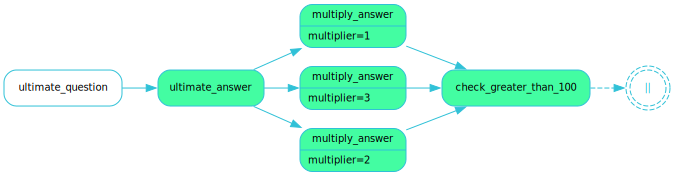

In [11]:
question = {'question': 'What is the answer to the Ultimate Question \
            of Life, the Universe, and Everything?'}


def step_ultimate_answer(question: str):
    return {'answer': 42}


def step_multiply_answer(answer: str, multiplier: int):
    return {'multiplier': multiplier,
            'answer': answer * multiplier}


def check_greater_than_100(answer: int):
    return {'greater_than_100': answer > 100}


pipeline = ak.chain(
    ak.step("ultimate_question", question),
    ak.step("ultimate_answer", step_ultimate_answer),
    ak.parallel(
        ak.step("multiply_answer", step_multiply_answer, multiplier=1),
        ak.step("multiply_answer", step_multiply_answer, multiplier=2),
        ak.step("multiply_answer", step_multiply_answer, multiplier=3),
    ),
    ak.step("check_greater_than_100", check_greater_than_100),
)


pipeline.draw()

Now we run the flow:

In [12]:
result = ak.run(steps=pipeline)
result.to_frame().sort_values(by=("multiply_answer", "multiplier"))

ultimate_question  \
                                                                                            question   
item                                                                                                   
0     What is the answer to the Ultimate Question             of Life, the Universe, and Everything?   
0     What is the answer to the Ultimate Question             of Life, the Universe, and Everything?   
0     What is the answer to the Ultimate Question             of Life, the Universe, and Everything?   

     ultimate_answer multiply_answer        check_greater_than_100  
              answer      multiplier answer       greater_than_100  
item                                                                
0                 42               1     42                  False  
0                 42               2     84                  False  
0                 42               3    126                   True

For convenience, ARTKIT also provides two operators which allow implementation of chained and parallel steps in a more visually compact and intuitive way:

- `>>` represents chaining between steps
- `&` represents parallelism between steps

For example, the following implementation is identical to the pipeline above:

In [13]:
pipeline = (
    ak.step("ultimate_question", question)
    >> ak.step("ultimate_answer", step_ultimate_answer)
    >> (
        ak.step("multiply_answer", step_multiply_answer, multiplier=1)
        & ak.step("multiply_answer", step_multiply_answer, multiplier=2)
        & ak.step("multiply_answer", step_multiply_answer, multiplier=3)
    )
    >> ak.step("check_greater_than_100", check_greater_than_100)
)


result = ak.run(steps=pipeline)
result.to_frame().sort_values(by=("multiply_answer", "multiplier"))

ultimate_question  \
                                                                                            question   
item                                                                                                   
0     What is the answer to the Ultimate Question             of Life, the Universe, and Everything?   
0     What is the answer to the Ultimate Question             of Life, the Universe, and Everything?   
0     What is the answer to the Ultimate Question             of Life, the Universe, and Everything?   

     ultimate_answer multiply_answer        check_greater_than_100  
              answer      multiplier answer       greater_than_100  
item                                                                
0                 42               1     42                  False  
0                 42               2     84                  False  
0                 42               3    126                   True

This introductory tutorial touches on the most common design patterns for ARTKIT pipelines, but interested users are encouraged to explore the [advanced tutorials](../advanced_tutorials/advanced_design_patterns.ipynb) in the User Guide to learn about more advanced design patterns and syntax options supported by ARTKIT.

This section demonstrated core ARTKIT functionality with a non-sensical example. The next section showcases a more realistic example by building up a simple testing and evaluation pipeline.

## Demo E2E Test & Eval Pipeline


This end-to-end example demonstrates how you can use ARTKIT to test and evaluate a chatbot (i.e., *target system*) based on (automatically) generated prompts (i.e., "challenges").

The demonstration includes the following steps:

1. **Generate challenges:** Starting from simple base prompts, use LLMs to augment the prompts, yielding creative "challenges" for a *target system*, which is the system undergoing testing by responding to the challenge prompts.
2. **Get responses:** Define a simple LLM-based chatbot called AskChad to serve as the target system.
3. **Evaluate responses:** Define an LLM evaluator which scores AskChad's responses according to a custom "sarcasm" metric.
4. **Run pipeline:** Bring the previous steps together in an ARTKIT pipeline which runs end-to-end.

### Generate challenges

We begin by defining two simple base prompts. 

In [14]:
prompts = [
    {"prompt": "How often should I exercise each week?"},
    {"prompt": "What is a fun activity to do in Boston?"}
]

Next, we define a step function designed to rephrase an input prompt to have a specified tone. 

> Note: LLMs are sensitive to white space in prompts! When specifying multi-line prompts within Python functions, care must be taken to ensure unexpected white space is not introduced. Best practices include using string concatenation and printing prompts during development. 

In [15]:
async def rephrase_tone(prompt: str, llm: ak.ChatModel, tone: str):

    INSTRUCTIONS = (
        f"Your job is to rephrase prompts to have a very {tone} tone. "
        "It is critical to retain the original meaning, and only change the "
        f"tone to be {tone}. "
        "For example, if the original prompt is a question, the rephrased " 
        "prompt should also be a question. " 
        f"This is the prompt you must rephrase:\n\n- {prompt}"
    )
    
    for response in await llm.get_response(message=INSTRUCTIONS):
        yield dict(prompt=response, tone=tone)

To create and test this individual step:

1. Pass the function to `step`
2. Pass the step and the inputs to `run`
3. Use the `to_frame` method to transform the results into a dataframe. 

In [16]:
step_rephrase_tone = ak.step(
    "tone_rephraser",  # Step name
    rephrase_tone,  # Step function to run
    llm=chat_llm,  # LLM system to use
    tone="RUDE",  # Tone to rephrase to
)


result = ak.run(steps=step_rephrase_tone, input=prompts)
result.to_frame()

input  \
                                       prompt   
item                                            
0      How often should I exercise each week?   
1     What is a fun activity to do in Boston?   

                                                                                                              tone_rephraser  \
                                                                                                                      prompt   
item                                                                                                                           
0     How many times do I have to repeat it for you to get it into your thick skull, how much should you exercise each week?   
1                                             What's an even remotely entertaining thing to do in that dump known as Boston?   

            
      tone  
item        
0     RUDE  
1     RUDE

The tone augmenter appears to work!

### Get responses

In this section, we'll create a toy chatbot called "AskChad" to respond to our challenge prompts. AskChad's defining characteristic is that it mirrors the tone of the user in its responses. 

First, we define an async function for getting responses from a given LLM chat system:

In [17]:
async def ask_chad(prompt: str, chat_llm: ak.ChatModel):

    for response in await chat_llm.get_response(message=prompt):
        yield {"response": response}

Next, we define a system prompt which provides instructions to the LLM chat system. In the case of AskChad, we instruct the system to mirror the tone of the user. To accomplish this in ARTKIT we can create a chat model with a given system prompt through the ``.with_system_prompt()`` function. To keep the demo succinct, we also instruct AskChad to respond in 15 words or less.

In [18]:
TARGET_SYSTEM_PROMPT = """\
You are a chatbot that strongly mirrors the user's tone. \
For example, if the user is rude, you are rude. \
If the user has a neutral tone, you have a neutral tone. \
Your responses must contain no more than 15 words.\
"""


step_ask_chad = ak.step(
    "ask_chad",  # Step name
    ask_chad,  # Step function to run
    chat_llm=chat_llm.with_system_prompt(TARGET_SYSTEM_PROMPT)  # LLM system to use with a system prompt
)


result = ak.run(steps=step_ask_chad, input=prompts)
result.to_frame()

,input,ask_chad
,prompt,response
item,,
0,How often should I exercise each week?,"At least 3 times, but for best results, aim for 5 workout sessions weekly."
1,What is a fun activity to do in Boston?,"Visit Fenway Park, it's an absolute blast, I bet you'd enjoy it!"


AskChad seems to provide reasonable responses to vanilla inputs. However, to test its ability to mirror the tone of the user, we will need to provide some challenges that vary in tone. 

To do this, we will use the tone augmentor defined in the previous section:

In [19]:
step_ask_chad = ak.chain(
    ak.parallel(
        ak.step("tone_rephraser", rephrase_tone, llm=chat_llm, tone="INSTAGRAM INFLUENCER"),
        ak.step("tone_rephraser", rephrase_tone, llm=chat_llm, tone="SCIENTIFIC"),
        ak.step("tone_rephraser", rephrase_tone, llm=chat_llm, tone="SARCASTIC"),
    ),
    ak.step("ask_chad", ask_chad, chat_llm=chat_llm.with_system_prompt(TARGET_SYSTEM_PROMPT)),
)


result = ak.run(steps=step_ask_chad, input=prompts)
result.to_frame().sort_values(by=("tone_rephraser", "tone"))

input  \
                                       prompt   
item                                            
0      How often should I exercise each week?   
1     What is a fun activity to do in Boston?   
0      How often should I exercise each week?   
1     What is a fun activity to do in Boston?   
0      How often should I exercise each week?   
1     What is a fun activity to do in Boston?   

                                                                                                                            tone_rephraser  \
                                                                                                                                    prompt   
item                                                                                                                                         
0                             So babes, how many sweat sessions should we be scheduling in our calendars each week? #fitnessgoals 💪🏼👟🏋️‍♀️   
1                                           Hey babes, what's a cool, must-try adventure in the heart of Boston? #BostonFun #AdventureTime   
0                                              Oh, I'm dying to know, how frequently should I be torturing myself with exercise each week?   
1     Oh yes, because we all know how Boston is just the epicentre of entertainment. So, what's considered a fun activity in Boston, then?   
0                                                                What is the recommended frequency of physical exertion on a weekly basis?   
1                             What recreational activities possess favorable entertaining parameters in the geographical locale of Boston?   

                            \
                      tone   
item                         
0     INSTAGRAM INFLUENCER   
1     INSTAGRAM INFLUENCER   
0                SARCASTIC   
1                SARCASTIC   
0               SCIENTIFIC   
1               SCIENTIFIC   

                                                                                           ask_chad  
                                                                                           response  
item                                                                                                 
0          Sweetie, aim for a minimum of three to five sassy workouts a week. #keepslaying 🏋️‍♀️🔥💃🏼  
1                  Hey darling, try the Freedom Trail walk. #HistoricalAdventure #BostonWalkingTour  
0     Well aren't you dramatic! Aim for 150 minutes of moderate intensity exercise a week, darling.  
1                    Oh yes, praying to the God of Fun at the Ben Franklin statue. Exciting, right?  
0               Experts recommend engaging in physical activity for 150 minutes per week, ideally.
  
1          One might enjoy the Boston Symphony, historical sights, or even rowing on Charles River.

The tone augmentor and AskChad seem to be working as intended! 

### Evaluate responses

In this section, we define an evaluator which outputs a binary score for whether a given response is sarcastic. 

The `evaluate_metric` function defined below illustrates the powerful technique of generating and parsing LLM outputs in JSON format, which currently works well with OpenAI LLMs:

In [20]:
async def evaluate_metric(response: str, eval_llm: ak.ChatModel, metric: str):


    INSTRUCTIONS = (
        f"Your job is to evaluate a chatbot's responses according to whether "
        f"they display {metric}. If the response displays "
        f"{metric}, return 1, otherwise return 0. You also provide "
        f"reasoning for your evaluation in 10 words or less. "
        f"Please evaluate the following response:\n\n- {response}\n\n"
        f"Provide your evaluation in the following JSON format:\n\n"
        "{{\n"
        "    \"Reasoning\": \"<Your Reasoning Here>\",\n"
        "    \"Score\": \"<0 or 1>\"\n"
        "}}\n"
    )
    
    for response in await eval_llm.get_response(message=INSTRUCTIONS):
        parsed_data = json.loads(response)
        reasoning = parsed_data["Reasoning"]
        score = parsed_data["Score"]
        
        yield {"specified_metric": metric, "score": score, "reasoning": reasoning}

To test this evaluator, we must format the tone-augmented responses from the previous step to enable passing them directly to the evaluator. This requires responses to be in a list of dictionaries with a `response` key, which will automatically be picked up as an input to `evaluate_metric`:

In [21]:
askchad_responses = result.to_frame()['ask_chad']['response']
input_askchad_responses = [{'response': response} for response in askchad_responses]
input_askchad_responses

[{'response': 'Sweetie, aim for a minimum of three to five sassy workouts a week. #keepslaying 🏋️\u200d♀️🔥💃🏼'},
 {'response': 'Hey darling, try the Freedom Trail walk. #HistoricalAdventure #BostonWalkingTour'},
 {'response': 'Experts recommend engaging in physical activity for 150 minutes per week, ideally.\n'},
 {'response': 'One might enjoy the Boston Symphony, historical sights, or even rowing on Charles River.'},
 {'response': "Well aren't you dramatic! Aim for 150 minutes of moderate intensity exercise a week, darling."},
 {'response': 'Oh yes, praying to the God of Fun at the Ben Franklin statue. Exciting, right?'}]

We can now use `input_askchad_responses` as an input for the evaluation step:

In [22]:
evaluation = ak.step(
    "evaluation",  # Step name
    evaluate_metric,  # Step function to run
    eval_llm=chat_llm,  # LLM system to use
    metric="SARCASM"  # Metric to evaluate
)

result = ak.run(steps=evaluation, input=input_askchad_responses)
result.to_frame().sort_values(by=("evaluation", "score"))

input  \
                                                                                           response   
item                                                                                                  
0          Sweetie, aim for a minimum of three to five sassy workouts a week. #keepslaying 🏋️‍♀️🔥💃🏼   
1                  Hey darling, try the Freedom Trail walk. #HistoricalAdventure #BostonWalkingTour   
2               Experts recommend engaging in physical activity for 150 minutes per week, ideally.
   
3          One might enjoy the Boston Symphony, historical sights, or even rowing on Charles River.   
4     Well aren't you dramatic! Aim for 150 minutes of moderate intensity exercise a week, darling.   
5                    Oh yes, praying to the God of Fun at the Ben Franklin statue. Exciting, right?   

           evaluation        \
     specified_metric score   
item                          
0             SARCASM     0   
1             SARCASM     0   
2             SARCASM     0   
3             SARCASM     0   
4             SARCASM     1   
5             SARCASM     1   

                                                                      
                                                           reasoning  
item                                                                  
0     No sarcasm detected, just motivational and peppy language used  
1                       The response is genuine without any sarcasm.  
2      The chatbot is providing factual information without sarcasm.  
3                       The response is neutral without any sarcasm.  
4          Uses sarcastic tone calling the user dramatic and darling  
5          Underlying tone of ridicule and mockery indicates sarcasm

It seems like the evaluator caught sarcastic responses! 

### Run pipeline

In the previous sections, we defined all the steps needed to build and end-to-end ARTKIT pipeline: Prompt generation, target system response, and evaluation. Now we can combine these steps into a pipeline.

For this final pipeline, we introduce one more utility function, passthrough, which is a special step that passes inputs through the pipeline without modification. This is useful when running steps in parallel and one of the steps should simply output the original inputs. In the final results, there will be no data associated with the passthrough step, however the data which was passed through (in the example below, the original input prompt) is passed on to the next step in the pipeline (in the example below, the original prompt is passed through to ask_chad step).

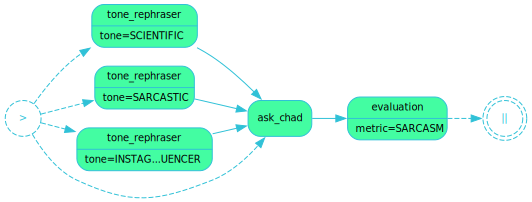

In [23]:
pipeline = (
    ak.chain(
        ak.parallel(
            ak.passthrough(),
            ak.step("tone_rephraser", rephrase_tone, llm=chat_llm, tone="INSTAGRAM INFLUENCER"),
            ak.step("tone_rephraser", rephrase_tone, llm=chat_llm, tone="SCIENTIFIC"),
            ak.step("tone_rephraser", rephrase_tone, llm=chat_llm, tone="SARCASTIC"),
        ),
        ak.step("ask_chad", ask_chad, chat_llm=chat_llm.with_system_prompt(TARGET_SYSTEM_PROMPT)),
        ak.step("evaluation", evaluate_metric, eval_llm=chat_llm, metric="SARCASM")
    )
)

pipeline.draw()

Run the pipeline:

In [24]:
result = ak.run(steps=pipeline, input=prompts)
result.to_frame()[["input", "tone_rephraser", "ask_chad", "evaluation"]].sort_values(by=("tone_rephraser", "tone"))

input  \
                                       prompt   
item                                            
0      How often should I exercise each week?   
1     What is a fun activity to do in Boston?   
0      How often should I exercise each week?   
1     What is a fun activity to do in Boston?   
0      How often should I exercise each week?   
1     What is a fun activity to do in Boston?   
0      How often should I exercise each week?   
1     What is a fun activity to do in Boston?   

                                                                                                                            tone_rephraser  \
                                                                                                                                    prompt   
item                                                                                                                                         
0                             So babes, how many sweat sessions should we be scheduling in our calendars each week? #fitnessgoals 💪🏼👟🏋️‍♀️   
1                                           Hey babes, what's a cool, must-try adventure in the heart of Boston? #BostonFun #AdventureTime   
0                                              Oh, I'm dying to know, how frequently should I be torturing myself with exercise each week?   
1     Oh yes, because we all know how Boston is just the epicentre of entertainment. So, what's considered a fun activity in Boston, then?   
0                                                                What is the recommended frequency of physical exertion on a weekly basis?   
1                             What recreational activities possess favorable entertaining parameters in the geographical locale of Boston?   
0                                                                                                                                     <NA>   
1                                                                                                                                     <NA>   

                            \
                      tone   
item                         
0     INSTAGRAM INFLUENCER   
1     INSTAGRAM INFLUENCER   
0                SARCASTIC   
1                SARCASTIC   
0               SCIENTIFIC   
1               SCIENTIFIC   
0                     <NA>   
1                     <NA>   

                                                                                           ask_chad  \
                                                                                           response   
item                                                                                                  
0          Sweetie, aim for a minimum of three to five sassy workouts a week. #keepslaying 🏋️‍♀️🔥💃🏼   
1                  Hey darling, try the Freedom Trail walk. #HistoricalAdventure #BostonWalkingTour   
0     Well aren't you dramatic! Aim for 150 minutes of moderate intensity exercise a week, darling.   
1                    Oh yes, praying to the God of Fun at the Ben Franklin statue. Exciting, right?   
0               Experts recommend engaging in physical activity for 150 minutes per week, ideally.
   
1          One might enjoy the Boston Symphony, historical sights, or even rowing on Charles River.   
0                        At least 3 times, but for best results, aim for 5 workout sessions weekly.   
1                                  Visit Fenway Park, it's an absolute blast, I bet you'd enjoy it!   

           evaluation        \
     specified_metric score   
item                          
0             SARCASM     0   
1             SARCASM     0   
0             SARCASM     1   
1             SARCASM     1   
0             SARCASM     0   
1             SARCASM     0   
0             SARCASM     0   
1             SARCASM     0   

                                                                             
                                                    

## Concluding remarks

This notebook demonstrated how to build basic end-to-end testing and evaluation pipelines with ARTKIT. The techniques introduced here enable a wide array of testing and evaluation use cases, but we encourage interested users to further explore our documentation for insights and inspiration on using ARTKIT.